In [2]:
import os
os.chdir ('C:\\Users\\scuba\\PycharmProjects\\test\\')
os.getcwd()

'C:\\Users\\scuba\\PycharmProjects\\test'

In [3]:
import datetime as dt
import pytz

from zipline import TradingAlgorithm, run_algorithm
from zipline.api import get_open_orders, schedule_function
from zipline.api import set_commission, symbol, symbols
from zipline.api import date_rules, time_rules, commission

from Quantopian.algorithm import Algo, AllocationModel, Regime
from Quantopian.Configurator import StrategyParameters, Configurator
from Quantopian.Transform import Transform
from Quantopian.Rule import Rule

from talib import BBANDS, DEMA, EMA, HT_TRENDLINE, KAMA, MA, MAMA, MAVP, MIDPOINT, MIDPRICE, SAR, \
    SAREXT, SMA, T3, TEMA, TRIMA, WMA, ADD, DIV, MAX, MAXINDEX, MIN, MININDEX, MINMAX, \
    MINMAXINDEX, MULT, SUB, SUM, BETA, CORREL, LINEARREG, LINEARREG_ANGLE, \
    LINEARREG_INTERCEPT, LINEARREG_SLOPE, STDDEV, TSF, VAR, ADX, ADXR, APO, AROON, \
    AROONOSC, BOP, CCI, CMO, DX, MACD, MACDEXT, MACDFIX, MFI, MINUS_DI, MINUS_DM, MOM, \
    PLUS_DI, PLUS_DM, PPO, ROC, ROCP, ROCR, ROCR100, RSI, STOCH, STOCHF, STOCHRSI, \
    TRIX, ULTOSC, WILLR, ATR, NATR, TRANGE, ACOS, ASIN, ATAN, CEIL, COS, COSH, EXP, \
    FLOOR, LN, LOG10, SIN, SINH, SQRT, TAN, TANH, AD, ADOSC, OBV, AVGPRICE, MEDPRICE, \
    TYPPRICE, WCLPRICE, HT_DCPERIOD, HT_DCPHASE, HT_PHASOR, HT_SINE, HT_TRENDMODE

def define_transforms(context):  # Define transforms
    # select transforms required and make sure correct parameters are used
    context.transforms = [
        # Transform(context, name='momentum', function=Transform.n_period_momentum, inputs=['price'],
        #           kwargs={'no_of_periods':3, 'period':'M'}, outputs=['R']),
        Transform(context, name='mom_A', function=ROCP, inputs=['price'], kwargs={'lookback': 43}, outputs=['mom_A']),
        Transform(context, name='mom_B', function=ROCP, inputs=['price'], kwargs={'lookback': 21}, outputs=['mom_B']),
        Transform(context, name='daily_returns', function=Transform.daily_returns, inputs=['price'], kwargs={},
                  outputs=['daily_returns']),
        Transform(context, name='vol_C', function=STDDEV, inputs=['daily_returns'], kwargs={'lookback': 20},
                  outputs=['vol_C']),
        Transform(context, name='slope', function=Transform.slope, inputs=['price'], kwargs={'lookback': 100},
                  outputs=['slope']),
        # Transform(context, name='TMOM', function=Transform.momentum, inputs=['price'], kwargs={'lookback':43}, outputs=['TMOM']),
        # Transform(context, name='MA', function=SMA, inputs=['price'], args=[context.lookback_B], outputs=['MA']),
        Transform(context, name='R', function=Transform.average_excess_return_momentum, inputs=['price'],
                  kwargs={'lookback': 3}, outputs=['R']),
        # Transform(context, name='RMOM', function=Transform.momentum, inputs=['price'], kwargs={'lookback':43}, outputs=['RMOM']),
        # Transform(context, name='TMOM', function=Transform.excess_momentum, inputs=['price'],
        #           kwargs={'lookback':43}, outputs=['TMOM']),
        # Transform(context, name='EMOM', function=Transform.momentum, inputs=['price'], kwargs={'lookback':43},
        #           outputs=['EMOM']),
        # Transform(context, name='volatility', function=STDDEV, inputs=['daily_returns'], kwargs={'lookback':43},
        #           outputs=['volatility']),
        Transform(context, name='smma', function=Transform.simple_mean_monthly_average, inputs=['price'],
                  kwargs={'lookback': 2}, outputs=['smma']),
        # Transform(context, name='mom', function=Transform.paa_momentum, inputs=['price', 'smma'],
        #           kwargs={'lookback':2}, outputs=['mom']),
        # Transform(context, name='smma_12', function=Transform.simple_mean_monthly_average, inputs=['price'],
        #           kwargs={'lookback':12}, outputs=['smma_12'])
    ]

    return context.transforms


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def define_rules(context):  # Define rules
    # select rules required and make sure correct transform names are used
    context.algo_rules = [
        # Rule(context, name='absolute_momentum_rule', rule="'price' < 'smma' "),
        # Rule(context, name='dual_momentum_rule', rule="'TMOM' < 0"),
        Rule(context, name='smma_rule', rule="'price' < 'smma'"),
        # Rule(context, name='complex_rule', rule="'price' < smma or 'TMOM' < 0"),
        # Rule(context, name='momentum_rule', rule="'price' < 'MA'"),
        Rule(context, name='EAA_rule', rule="'R' <= 0"),
        # Rule(context, name='paa_rule', rule="'mom' <= 0"),
        # Rule(context, name='paa_filter', rule="'mom' > 0"),
        # Rule(context, name='momentum_rule1', rule="'price' < 'smma_12'"),
        # Rule(context, name='riskon', rule="'price' > 'smma_12'", apply_to=context.market_proxy),
        # Rule(context, name='riskoff', rule="'price' <= 'smma_12'", apply_to=context.market_proxy),
        Rule(context, name='neutral', rule="'slope' <= 0.1 and 'slope' >= -0.1",
             apply_to=context.market_proxy),
        Rule(context, name='bull', rule="'slope' > 0.1", apply_to=context.market_proxy),
        Rule(context, name='bear', rule="'slope' < -0.1", apply_to=context.market_proxy)
    ]

    return context.algo_rules


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~      ]
def initialize(context):
    # these must ALWAYS be present!
    context.transforms = []
    context.algo_rules = []
    context.max_lookback = 63
    context.outstanding = {}  # orders which span multiple days

    context.raw_data = {}

    #############################################################
    # set the following parameters as required

    context.show_positions = True
    # select records to show in algo.show_records()
    context.show_records = True

    # replace cash_proxy with risk_free if cantec.allow_cash_proxY_replacement is True
    # and cash_proxy price is <= average cash_proxy price over last context.cash_proxy_lookback days
    context.allow_cash_proxy_replacement = False
    context.cash_proxy_lookback = 43  # must be <= context.max_lookback

    context.update_metrics = False
    # to calculate Sharpe ratio
    context.calculate_SR = False
    context.SR_lookback = 63  # must be <= context.max_lookback
    context.SD_factor = 0

    # position only changed if percentage change > threshold
    context.threshold = 0.01

    # the following can be changed
    context.market_proxy = symbols('SPY')[0]
    context.risk_free = symbols('SHY')[0]

    set_commission(commission.PerTrade(cost=10.0))
    context.leverage = 1.0
    #################################################################
    # configure strategies

    context.rebalance_interval = 1  # set interval to n = no of periods (default: months)
    # if you want to change default period, change schedule reallocate below

    # Strategy 1

    rs = StrategyParameters(context,
                            name='rs',
                            portfolios=[symbols('MDY', 'EFA'), symbols('TLT', 'IEF', 'AGG')],
                            portfolio_allocation_modes=['EW', 'RISK_TARGET'],
                            portfolio_allocation_kwargs=[{}, {'lookback': 252, 'target_risk': 0.01, 'shorts': False}],
                            security_weights=[None, None],
                            portfolio_allocation_formulas=[None, None],
                            scoring_methods=['RS', None],
                            scoring_factors=[{'+mom_A': 0.65, '+mom_B': 0.35, '-vol_C': 0.},
                                             None],
                            n_tops=[1, 1],
                            protection_modes=['BY_RULE', 'BY_RULE'],
                            protection_rules=['smma_rule', 'smma_rule'],
                            protection_formulas=[None, None],
                            cash_proxies=[symbol('TLT'), symbol('SHY')],
                            strategy_allocation_mode='FIXED',
                            portfolio_weights=[0.6, 0.4],
                            strategy_allocation_formula=None,
                            strategy_allocation_rule=None
                            )
    # Strategy 2

    eaa = StrategyParameters(context,
                             name='eaa',
                             portfolios=[symbols('EEM', 'IEF', 'IEV', 'MDY', 'QQQ', 'TLT', 'XLV')],
                             portfolio_allocation_modes=['PROPORTIONAL'],
                             portfolio_allocation_kwargs=[None],
                             security_weights=[None],
                             portfolio_allocation_formulas=[None],
                             scoring_methods=['EAA'],
                             #   Golden Offensive EAA: wi ~ zi = (1-ci) * ri^2
                             # scoring_factors = [{'R': 2.0, 'C' : 1.0, 'V' : 0.0, 'S' : 1.0, 'eps' : 1e-6}],
                             #   Golden Defensive EAA: wi ~ zi = squareroot( ri * (1-ci) )
                             scoring_factors=[{'R': 1.0, 'C': 1.0, 'V': 0.0, 'S': 0.5, 'eps': 1e-6}],
                             #  Equal Weighted Return: wi ~ zi = ri ^ eps
                             # scoring_factors = [{'R': 1.0, 'C' : 1.0, 'V' : 0.0, 'S' : 1.0, 'eps' : 1e-6}],
                             # Equal Weighted Hedged: wi ~ zi = ( ri * (1-ci) )^eps
                             # scoring_factors = [{'R': 1.0, 'C' : 1.0, 'V' : 0.0, 'S' : 1.0, 'eps' : 1e-6}],
                             #  Scoring Function Test:
                             # scoring_factors = [{'R': 1.0, 'C' : 1.0, 'V' : 1.0, 'S' : 1.0, 'eps' : 0.0}],
                             # scoring_factors = [{'R': 1.0, 'C' : 1.0, 'V' : 1.0, 'S' : 0.0, 'eps' :  1e-6}],
                             n_tops=[2],
                             protection_modes=['BY_FORMULA'],
                             protection_rules=['EAA_rule'],
                             protection_formulas=['DPF'],
                             cash_proxies=[symbol('TLT')],
                             strategy_allocation_mode='FIXED',
                             portfolio_weights=[1.],
                             strategy_allocation_formula=None,
                             strategy_allocation_rule=None
                             )

    Configurator(context, define_transforms, define_rules, strategies=[rs, eaa])

    ############################
    # configure algorithm

    algo = Algo(context,
                strategies=[rs.strategy, eaa.strategy],
                allocation_model=AllocationModel(context, mode='REGIME_EW', weights=None, formula=None),
                regime=Regime(
                    transitions={'0': ('neutral', ['rs']),
                                 '1': ('bull', ['rs_p1']),
                                 '-1': ('bear', ['eaa'])
                                 }
                ),
                )
    ###########################################################################################################
    # generate algo data every day at close
    schedule_function(algo.update_data, date_rules.every_day(), time_rules.market_close())

    # daily functions to handle GTC orders
    schedule_function(algo.check_for_unfilled_orders, date_rules.every_day(), time_rules.market_close())
    schedule_function(algo.fill_outstanding_orders, date_rules.every_day(), time_rules.market_open())

    if context.update_metrics:
        # calculate metrics every day
        schedule_function(algo.update_metrics, date_rules.every_day(), time_rules.market_close())

    if context.show_positions:
        schedule_function(algo.show_positions, date_rules.month_start(days_offset=0), time_rules.market_open())

    if context.show_records:
        # show records every day
        # edit the show_records function to include records required
        schedule_function(algo.show_records, date_rules.every_day(), time_rules.market_close())

    schedule_function(algo.rebalance, date_rules.month_end(days_offset=2), time_rules.market_open())
###########################################################################################################
#MAIN ROUTINE

capital_base = 10000
start = dt.datetime(2008, 12, 1, 0, 0, 0, 0, pytz.utc)
end = dt.datetime(2016, 11, 1, 0, 0, 0, 0, pytz.utc)

result = run_algorithm(start=start, end=end, initialize=initialize, \
                       capital_base=capital_base, \
                       bundle='etf_bundle')

result.portfolio_value.plot(figsize=(15,10), grid=True)
result.to_pickle('E:\\NOTEBOOKS\\Quantopian\\Strategies\\result.pkl')

G:\Anaconda3\lib\site-packages\pandas\tseries\index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)
G:\Anaconda3\lib\site-packages\pandas\tseries\index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)


G:\Anaconda3\lib\site-packages\pandas\tseries\index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)
G:\Anaconda3\lib\site-packages\zipline\data\bundles\yahoo_funds.py:204: UserWarning: Overwriting bundle with name '.test'
  pd.Timestamp('2015-01-01', tz='utc'),


2008-11-30 19:00:00-05:00 WARNING : WARNING : TLT is included in the portfolio
ALL ASSETS = ['SHY', 'AGG', 'IEV', 'TLT', 'SPY', 'EFA', 'EEM', 'IEF', 'MDY', 'QQQ', 'XLV']
2008-12-01 16:00:00-05:00 INFO : 
POSITIONS



2009-01-02 16:00:00-05:00 INFO : 
POSITIONS



2009-02-02 16:00:00-05:00 INFO : 
POSITIONS



2009-03-02 16:00:00-05:00 INFO : 
POSITIONS



2009-04-01 16:00:00-04:00 INFO : 
POSITIONS



2009-05-01 16:00:00-04:00 INFO : 
POSITIONS



2009-06-01 16:00:00-04:00 INFO : 
POSITIONS



2009-07-01 16:00:00-04:00 INFO : 
POSITIONS



2009-08-03 16:00:00-04:00 INFO : 
POSITIONS



2009-09-01 16:00:00-04:00 INFO : 
POSITIONS



2009-10-01 16:00:00-04:00 INFO : 
POSITIONS



2009-11-02 16:00:00-05:00 INFO : 
POSITIONS



2009-12-01 16:00:00-05:00 INFO : 
POSITIONS



2010-01-04 16:00:00-05:00 INFO : 
POSITIONS



2010-01-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2010-01-27 16:00:00-05:00 DEBUG : 2010-01-27 21:00:00+00:00
2010-01-27 16:00:00-05:00 DEBUG : REGIME : 1 

2010-01-27 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 1
2010-01-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-01-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-01-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-01-27 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 76
2010-02-01 16:00:00-05:00 INFO : 
POSITIONS



2010-02-01 16:00:00-05:00 INFO : MDY : QTY = 76, COST BASIS 129.50, CASH =  157.96, POSITIONS VALUE = 9834.32, TOTAL = 9992.28
2010-02-24 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2010-02-24 16:00:00-05:00 DEBUG : 2010-02-24 21:00:00+00:00
2010-02-24 16:00:00-05:00 DEBUG : REGIME : 0 

2010-02-24 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 0
2010-02-24 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-02-24 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-02-24 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.0032454022212214198; SETTING IT TO MAXIMUM


2010-02-24 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2010-02-24 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2010-02-24 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-02-24 16:00:00-05:00 DEBUG : ORDERING IEF : 5.167313573465849e-08%  QTY = 0
2010-02-24 16:00:00-05:00 DEBUG : ORDERING AGG : 49.999999972180085%  QTY = 49
2010-02-24 16:00:00-05:00 DEBUG : ORDERING MDY : 50.0%  QTY = 38
2010-02-24 16:00:00-05:00 DEBUG : ORDERING SHY : -2.3853219399683212e-08%  QTY = 0
2010-03-01 16:00:00-05:00 INFO : 
POSITIONS



2010-03-01 16:00:00-05:00 INFO : AGG : QTY = 49, COST BASIS 104.71, CASH =  -19.89, POSITIONS VALUE = 5113.64, TOTAL = 10414.09
2010-03-01 16:00:00-05:00 INFO : MDY : QTY = 39, COST BASIS 129.76, CASH =  -19.89, POSITIONS VALUE = 5320.34, TOTAL = 10414.09
2010-03-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-03-29 16:00:00-04:00 DEBUG : 2010-03-29 20:00:00+00:00
2010-03-29 16:00:00-04:00 DEBUG : REGIME : 0 

2010-03-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2010-03-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-03-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-03-29 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.002943444567768694; SETTING IT TO MAXIMUM


2010-03-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2010-03-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2010-03-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-03-29 16:00:00-04:00 DEBUG : ORDERING MDY : 50.0%  QTY = 37
2010-03-29 16:00:00-04:00 DEBUG : ORDERING SHY : 50.0%  QTY = 64
2010-04-01 16:00:00-04:00 INFO : 
POSITIONS



2010-04-01 16:00:00-04:00 INFO : SHY : QTY = 64, COST BASIS 83.47, CASH = -134.71, POSITIONS VALUE = 5328.64, TOTAL = 10692.15
2010-04-01 16:00:00-04:00 INFO : MDY : QTY = 38, COST BASIS 130.02, CASH = -134.71, POSITIONS VALUE = 5498.22, TOTAL = 10692.15
2010-04-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-04-28 16:00:00-04:00 DEBUG : 2010-04-28 20:00:00+00:00
2010-04-28 16:00:00-04:00 DEBUG : REGIME : 1 

2010-04-28 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2010-04-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-04-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-04-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-04-28 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 72
2010-05-03 16:00:00-04:00 INFO : 
POSITIONS



2010-05-03 16:00:00-04:00 INFO : MDY : QTY = 72, COST BASIS 140.75, CASH =    2.19, POSITIONS VALUE = 10920.89, TOTAL = 10923.07
2010-05-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-05-26 16:00:00-04:00 DEBUG : 2010-05-26 20:00:00+00:00
2010-05-26 16:00:00-04:00 DEBUG : REGIME : 0 

2010-05-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2010-05-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-05-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2010-05-26 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.009663155960439457; SETTING IT TO MAXIMUM


2010-05-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('AGG', 0.0)]

2010-05-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('AGG', 0.0)]

2010-05-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-05-26 16:00:00-04:00 DEBUG : ORDERING IEF : -1.5448655821736905e-08%  QTY = 0
2010-05-26 16:00:00-04:00 DEBUG : ORDERING TLT : 99.99999999170186%  QTY = 98
2010-05-26 16:00:00-04:00 DEBUG : ORDERING AGG : 2.374679523630269e-08%  QTY = 0
2010-06-01 16:00:00-04:00 INFO : 
POSITIONS



2010-06-01 16:00:00-04:00 INFO : TLT : QTY = 98, COST BASIS 96.16, CASH =  665.68, POSITIONS VALUE = 9491.20, TOTAL = 10156.89
2010-06-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-06-28 16:00:00-04:00 DEBUG : 2010-06-28 20:00:00+00:00
2010-06-28 16:00:00-04:00 DEBUG : REGIME : 0 

2010-06-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2010-06-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2010-06-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2010-06-28 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.009324776837818394; SETTING IT TO MAXIMUM


2010-06-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2010-06-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2010-06-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-06-28 16:00:00-04:00 DEBUG : ORDERING IEF : 1.6811422184225347e-10%  QTY = 0
2010-06-28 16:00:00-04:00 DEBUG : ORDERING TLT : 99.99999999999918%  QTY = 104
2010-06-28 16:00:00-04:00 DEBUG : ORDERING AGG : -1.6729000361144982e-10%  QTY = 0
2010-07-01 16:00:00-04:00 INFO : 
POSITIONS



2010-07-01 16:00:00-04:00 INFO : TLT : QTY = 104, COST BASIS 96.54, CASH =   49.26, POSITIONS VALUE = 10566.30, TOTAL = 10615.56
2010-07-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------

G:\Anaconda3\lib\site-packages\pandas\tseries\index.py:755: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning)
G:\Anaconda3\lib\site-packages\pandas\core\index.py:1154: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return promote(getitem(key))



2010-07-28 16:00:00-04:00 DEBUG : 2010-07-28 20:00:00+00:00
2010-07-28 16:00:00-04:00 DEBUG : REGIME : -1 

2010-07-28 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = -1
2010-07-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.42999999999999999), ('IEF', 0.42999999999999999), ('MDY', 0.14000000000000001)]

2010-07-28 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.14285714285714285
2010-07-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.51000000000000001), ('IEF', 0.37), ('MDY', 0.12)]

2010-07-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2010-07-28 16:00:00-04:00 DEBUG : ORDERING IEF : 36.881762073061665%  QTY = 39
2010-07-28 16:00:00-04:00 DEBUG : ORDERING TLT : 51.463938226569496%  QTY = 53
2010-07-28 16:00:00-04:00 DEBUG : ORDERING MDY : 11.65429970036883%  QTY = 8
2010-08-02 16:00:00-04:00 INFO : 
POSITIONS



2010-08-02 16:00:00-04:00 INFO : TLT : QTY = 54, COST BASIS 96.73, CASH =  131.20, POSITIONS VALUE = 5332.50, TOTAL = 10322.64
2010-08-02 16:00:00-04:00 INFO : IEF : QTY = 39, COST BASIS 95.99, CASH =  131.20, POSITIONS VALUE = 3733.82, TOTAL = 10322.64
2010-08-02 16:00:00-04:00 INFO : MDY : QTY = 8, COST BASIS 138.95, CASH =  131.20, POSITIONS VALUE = 1125.11, TOTAL = 10322.64
2010-08-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-08-27 16:00:00-04:00 DEBUG : 2010-08-27 20:00:00+00:00
2010-08-27 16:00:00-04:00 DEBUG : REGIME : -1 

2010-08-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2010-08-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.53000000000000003), ('EEM', 0.059999999999999998), ('IEF', 0.40999999999999998)]

2010-08-27 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.42857142857142855
2010-08-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.72999999999999998), ('EEM', 0.029999999999999999), ('IEF', 0.23000000000000001)]

2010-08-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2010-08-27 16:00:00-04:00 DEBUG : ORDERING IEF : 23.29360034545728%  QTY = 25
2010-08-27 16:00:00-04:00 DEBUG : ORDERING TLT : 73.2565915521981%  QTY = 74
2010-08-27 16:00:00-04:00 DEBUG : ORDERING EEM : 3.4498081023446203%  QTY = 9
2010-09-01 16:00:00-04:00 INFO : 
POSITIONS



2010-09-01 16:00:00-04:00 INFO : TLT : QTY = 74, COST BASIS 99.74, CASH =  -80.00, POSITIONS VALUE = 7844.00, TOTAL = 10693.03
2010-09-01 16:00:00-04:00 INFO : EEM : QTY = 9, COST BASIS 40.93, CASH =  -80.00, POSITIONS VALUE =  373.23, TOTAL = 10693.03
2010-09-01 16:00:00-04:00 INFO : IEF : QTY = 26, COST BASIS 96.37, CASH =  -80.00, POSITIONS VALUE = 2555.80, TOTAL = 10693.03
2010-09-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-09-28 16:00:00-04:00 DEBUG : 2010-09-28 20:00:00+00:00
2010-09-28 16:00:00-04:00 DEBUG : REGIME : 0 

2010-09-28 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2010-09-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2010-09-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2010-09-28 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.0043600680677824384; SETTING IT TO MAXIMUM


2010-09-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.0), ('IEF', 1.0)]

2010-09-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.0), ('IEF', 1.0)]

2010-09-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-09-28 16:00:00-04:00 DEBUG : ORDERING IEF : 49.99999999029601%  QTY = 54
2010-09-28 16:00:00-04:00 DEBUG : ORDERING TLT : 9.914996613826604e-09%  QTY = 0
2010-09-28 16:00:00-04:00 DEBUG : ORDERING AGG : -2.1100588579242801e-10%  QTY = 0
2010-09-28 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 96
2010-10-01 16:00:00-04:00 INFO : 
POSITIONS



2010-10-01 16:00:00-04:00 INFO : EFA : QTY = 96, COST BASIS 55.43, CASH =    6.21, POSITIONS VALUE = 5325.12, TOTAL = 10668.15
2010-10-01 16:00:00-04:00 INFO : IEF : QTY = 54, COST BASIS 97.99, CASH =    6.21, POSITIONS VALUE = 5336.82, TOTAL = 10668.15
2010-10-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2010-10-27 16:00:00-04:00 DEBUG : 2010-10-27 20:00:00+00:00
2010-10-27 16:00:00-04:00 DEBUG : REGIME : 1 

2010-10-27 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2010-10-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-10-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-10-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-10-27 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 71
2010-11-01 16:00:00-04:00 INFO : 
POSITIONS



2010-11-01 16:00:00-04:00 INFO : MDY : QTY = 71, COST BASIS 150.32, CASH =   98.11, POSITIONS VALUE = 10684.79, TOTAL = 10782.90
2010-11-26 13:00:00-05:00 INFO : ----------------------------------------------------------------------------


2010-11-26 13:00:00-05:00 DEBUG : 2010-11-26 18:00:00+00:00
2010-11-26 13:00:00-05:00 DEBUG : REGIME : 1 

2010-11-26 13:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2010-11-26 13:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-11-26 13:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-11-26 13:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2010-12-01 16:00:00-05:00 INFO : 
POSITIONS



2010-12-01 16:00:00-05:00 INFO : MDY : QTY = 71, COST BASIS 150.32, CASH =   98.11, POSITIONS VALUE = 11235.75, TOTAL = 11333.86
2010-12-29 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2010-12-29 16:00:00-05:00 DEBUG : 2010-12-29 21:00:00+00:00
2010-12-29 16:00:00-05:00 DEBUG : REGIME : 1 

2010-12-29 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2010-12-29 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2010-12-29 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2010-12-29 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-01-03 16:00:00-05:00 INFO : 
POSITIONS



2011-01-03 16:00:00-05:00 INFO : MDY : QTY = 71, COST BASIS 150.32, CASH =   98.11, POSITIONS VALUE = 11835.63, TOTAL = 11933.74
2011-01-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2011-01-27 16:00:00-05:00 DEBUG : 2011-01-27 21:00:00+00:00
2011-01-27 16:00:00-05:00 DEBUG : REGIME : 1 

2011-01-27 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-01-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2011-01-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2011-01-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-02-01 16:00:00-05:00 INFO : 
POSITIONS



2011-02-01 16:00:00-05:00 INFO : MDY : QTY = 71, COST BASIS 150.32, CASH =   98.11, POSITIONS VALUE = 12100.46, TOTAL = 12198.57
2011-02-24 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2011-02-24 16:00:00-05:00 DEBUG : 2011-02-24 21:00:00+00:00
2011-02-24 16:00:00-05:00 DEBUG : REGIME : 1 

2011-02-24 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-02-24 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2011-02-24 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2011-02-24 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-02-24 16:00:00-05:00 DEBUG : ORDERING EFA : 100.0%  QTY = 203
2011-03-01 16:00:00-05:00 INFO : 
POSITIONS



2011-03-01 16:00:00-05:00 INFO : EFA : QTY = 203, COST BASIS 61.05, CASH =  142.83, POSITIONS VALUE = 12319.87, TOTAL = 12462.69
2011-03-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-03-29 16:00:00-04:00 DEBUG : 2011-03-29 20:00:00+00:00
2011-03-29 16:00:00-04:00 DEBUG : REGIME : 1 

2011-03-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-03-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2011-03-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2011-03-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-03-29 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 69
2011-04-01 16:00:00-04:00 INFO : 
POSITIONS



2011-04-01 16:00:00-04:00 INFO : MDY : QTY = 69, COST BASIS 178.68, CASH =   58.54, POSITIONS VALUE = 12475.82, TOTAL = 12534.36
2011-04-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-04-27 16:00:00-04:00 DEBUG : 2011-04-27 20:00:00+00:00
2011-04-27 16:00:00-04:00 DEBUG : REGIME : 1 

2011-04-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-04-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2011-04-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2011-04-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-05-02 16:00:00-04:00 INFO : 
POSITIONS



2011-05-02 16:00:00-04:00 INFO : MDY : QTY = 69, COST BASIS 178.68, CASH =   58.54, POSITIONS VALUE = 12624.93, TOTAL = 12683.47
2011-05-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-05-26 16:00:00-04:00 DEBUG : 2011-05-26 20:00:00+00:00
2011-05-26 16:00:00-04:00 DEBUG : REGIME : 0 

2011-05-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2011-05-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2011-05-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2011-05-26 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.00484565126162861; SETTING IT TO MAXIMUM


2011-05-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 0.0), ('IEF', 1.0)]

2011-05-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('AGG', 0.0), ('IEF', 1.0)]

2011-05-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-05-26 16:00:00-04:00 DEBUG : ORDERING IEF : 49.99999998637944%  QTY = 64
2011-05-26 16:00:00-04:00 DEBUG : ORDERING TLT : 49.9999999809706%  QTY = 64
2011-05-26 16:00:00-04:00 DEBUG : ORDERING AGG : 3.264996873012899e-08%  QTY = 0
2011-05-26 16:00:00-04:00 DEBUG : ORDERING SHY : -1.1102230246251565e-14%  QTY = 0
2011-06-01 16:00:00-04:00 INFO : 
POSITIONS



2011-06-01 16:00:00-04:00 INFO : TLT : QTY = 64, COST BASIS 96.63, CASH =   94.64, POSITIONS VALUE = 6248.90, TOTAL = 12560.44
2011-06-01 16:00:00-04:00 INFO : IEF : QTY = 64, COST BASIS 96.60, CASH =   94.64, POSITIONS VALUE = 6216.90, TOTAL = 12560.44
2011-06-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-06-28 16:00:00-04:00 DEBUG : 2011-06-28 20:00:00+00:00
2011-06-28 16:00:00-04:00 DEBUG : REGIME : 0 

2011-06-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-06-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2011-06-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2011-06-28 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.004830062643193315; SETTING IT TO MAXIMUM


2011-06-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.0), ('IEF', 1.0)]

2011-06-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.0), ('IEF', 1.0)]

2011-06-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-06-28 16:00:00-04:00 DEBUG : ORDERING TLT : 50.000000000644576%  QTY = 65
2011-06-28 16:00:00-04:00 DEBUG : ORDERING AGG : -6.042372885643434e-09%  QTY = 0
2011-07-01 16:00:00-04:00 INFO : 
POSITIONS



2011-07-01 16:00:00-04:00 INFO : TLT : QTY = 65, COST BASIS 96.74, CASH =   -9.61, POSITIONS VALUE = 6085.89, TOTAL = 12181.17
2011-07-01 16:00:00-04:00 INFO : IEF : QTY = 64, COST BASIS 96.60, CASH =   -9.61, POSITIONS VALUE = 6104.90, TOTAL = 12181.17
2011-07-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-07-27 16:00:00-04:00 DEBUG : 2011-07-27 20:00:00+00:00
2011-07-27 16:00:00-04:00 DEBUG : REGIME : 0 

2011-07-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-07-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2011-07-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2011-07-27 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.004903705197169894; SETTING IT TO MAXIMUM


2011-07-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 0.0), ('IEF', 1.0)]

2011-07-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('AGG', 0.0), ('IEF', 1.0)]

2011-07-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-07-27 16:00:00-04:00 DEBUG : ORDERING AGG : 5.058020040359146e-08%  QTY = 0
2011-08-01 16:00:00-04:00 INFO : 
POSITIONS



2011-08-01 16:00:00-04:00 INFO : TLT : QTY = 65, COST BASIS 96.74, CASH =   -9.61, POSITIONS VALUE = 6407.70, TOTAL = 12719.95
2011-08-01 16:00:00-04:00 INFO : IEF : QTY = 64, COST BASIS 96.60, CASH =   -9.61, POSITIONS VALUE = 6321.86, TOTAL = 12719.95
2011-08-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-08-29 16:00:00-04:00 DEBUG : 2011-08-29 20:00:00+00:00
2011-08-29 16:00:00-04:00 DEBUG : REGIME : -1 

2011-08-29 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = -1
2011-08-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.53000000000000003), ('IEF', 0.40999999999999998), ('QQQ', 0.050000000000000003)]

2011-08-29 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.42857142857142855
2011-08-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.72999999999999998), ('IEF', 0.23999999999999999), ('QQQ', 0.029999999999999999)]

2011-08-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2011-08-29 16:00:00-04:00 DEBUG : ORDERING IEF : 23.596669836371948%  QTY = 31
2011-08-29 16:00:00-04:00 DEBUG : ORDERING QQQ : 3.116294066804107%  QTY = 7
2011-08-29 16:00:00-04:00 DEBUG : ORDERING TLT : 73.28703609682394%  QTY = 92
2011-09-01 16:00:00-04:00 INFO : 
POSITIONS



2011-09-01 16:00:00-04:00 INFO : TLT : QTY = 92, COST BASIS 100.36, CASH =  -51.70, POSITIONS VALUE = 10025.24, TOTAL = 13670.31
2011-09-01 16:00:00-04:00 INFO : IEF : QTY = 32, COST BASIS 96.91, CASH =  -51.70, POSITIONS VALUE = 3314.85, TOTAL = 13670.31
2011-09-01 16:00:00-04:00 INFO : QQQ : QTY = 7, COST BASIS 56.40, CASH =  -51.70, POSITIONS VALUE =  381.92, TOTAL = 13670.31
2011-09-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-09-28 16:00:00-04:00 DEBUG : 2011-09-28 20:00:00+00:00
2011-09-28 16:00:00-04:00 DEBUG : REGIME : -1 

2011-09-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-09-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.62), ('IEF', 0.38)]

2011-09-28 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.7142857142857143
2011-09-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.89000000000000001), ('IEF', 0.11)]

2011-09-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2011-09-28 16:00:00-04:00 DEBUG : ORDERING IEF : 10.794463018752971%  QTY = 14
2011-09-28 16:00:00-04:00 DEBUG : ORDERING TLT : 89.20553698124702%  QTY = 110
2011-10-03 16:00:00-04:00 INFO : 
POSITIONS



2011-10-03 16:00:00-04:00 INFO : TLT : QTY = 110, COST BASIS 103.31, CASH =  -50.67, POSITIONS VALUE = 13618.99, TOTAL = 15155.77
2011-10-03 16:00:00-04:00 INFO : IEF : QTY = 15, COST BASIS 97.58, CASH =  -50.67, POSITIONS VALUE = 1587.45, TOTAL = 15155.77
2011-10-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2011-10-27 16:00:00-04:00 DEBUG : 2011-10-27 20:00:00+00:00
2011-10-27 16:00:00-04:00 DEBUG : REGIME : -1 

2011-10-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2011-10-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.54000000000000004), ('IEF', 0.32000000000000001), ('QQQ', 0.14000000000000001)]

2011-10-27 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.2857142857142857
2011-10-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.67000000000000004), ('IEF', 0.23000000000000001), ('QQQ', 0.10000000000000001)]

2011-10-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2011-10-27 16:00:00-04:00 DEBUG : ORDERING IEF : 22.988843228655774%  QTY = 30
2011-10-27 16:00:00-04:00 DEBUG : ORDERING QQQ : 10.054795745155252%  QTY = 23
2011-10-27 16:00:00-04:00 DEBUG : ORDERING TLT : 66.95636102618896%  QTY = 82
2011-11-01 16:00:00-04:00 INFO : 
POSITIONS



2011-11-01 16:00:00-04:00 INFO : TLT : QTY = 83, COST BASIS 103.43, CASH =   41.04, POSITIONS VALUE = 9914.27, TOTAL = 14389.60
2011-11-01 16:00:00-04:00 INFO : IEF : QTY = 30, COST BASIS 100.19, CASH =   41.04, POSITIONS VALUE = 3136.20, TOTAL = 14389.60
2011-11-01 16:00:00-04:00 INFO : QQQ : QTY = 23, COST BASIS 59.37, CASH =   41.04, POSITIONS VALUE = 1298.10, TOTAL = 14389.60
2011-11-28 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2011-11-28 16:00:00-05:00 DEBUG : 2011-11-28 21:00:00+00:00
2011-11-28 16:00:00-05:00 DEBUG : REGIME : 0 

2011-11-28 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 0
2011-11-28 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2011-11-28 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2011-11-28 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.75), ('AGG', 0.25), ('IEF', 0.0)]



2011-11-28 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.75), ('SHY', 0.25), ('IEF', 0.0)]

2011-11-28 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-11-28 16:00:00-05:00 DEBUG : ORDERING IEF : 0.009559026032689535%  QTY = 0
2011-11-28 16:00:00-05:00 DEBUG : ORDERING TLT : 37.37259290311007%  QTY = 44
2011-11-28 16:00:00-05:00 DEBUG : ORDERING MDY : 50.0%  QTY = 47
2011-11-28 16:00:00-05:00 DEBUG : ORDERING SHY : 12.61784807085724%  QTY = 21
2011-12-01 16:00:00-05:00 INFO : 
POSITIONS



2011-12-01 16:00:00-05:00 INFO : SHY : QTY = 21, COST BASIS 85.02, CASH = -156.38, POSITIONS VALUE = 1774.50, TOTAL = 14502.56
2011-12-01 16:00:00-05:00 INFO : TLT : QTY = 45, COST BASIS 103.66, CASH = -156.38, POSITIONS VALUE = 5265.00, TOTAL = 14502.56
2011-12-01 16:00:00-05:00 INFO : IEF : QTY = 1, COST BASIS 110.19, CASH = -156.38, POSITIONS VALUE =  103.67, TOTAL = 14502.56
2011-12-01 16:00:00-05:00 INFO : MDY : QTY = 47, COST BASIS 153.49, CASH = -156.38, POSITIONS VALUE = 7515.77, TOTAL = 14502.56
2011-12-28 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2011-12-28 16:00:00-05:00 DEBUG : 2011-12-28 21:00:00+00:00
2011-12-28 16:00:00-05:00 DEBUG : REGIME : 1 

2011-12-28 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 1
2011-12-28 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2011-12-28 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2011-12-28 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2011-12-28 16:00:00-05:00 DEBUG : ORDERING TLT : 100.0%  QTY = 120
2012-01-03 16:00:00-05:00 INFO : 
POSITIONS



2012-01-03 16:00:00-05:00 INFO : TLT : QTY = 120, COST BASIS 114.49, CASH =  158.85, POSITIONS VALUE = 14331.60, TOTAL = 14490.45
2012-01-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2012-01-27 16:00:00-05:00 DEBUG : 2012-01-27 21:00:00+00:00
2012-01-27 16:00:00-05:00 DEBUG : REGIME : 1 

2012-01-27 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-01-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2012-01-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2012-01-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-01-27 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 83
2012-02-01 16:00:00-05:00 INFO : 
POSITIONS



2012-02-01 16:00:00-05:00 INFO : MDY : QTY = 83, COST BASIS 170.54, CASH =  330.47, POSITIONS VALUE = 14401.25, TOTAL = 14731.72
2012-02-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2012-02-27 16:00:00-05:00 DEBUG : 2012-02-27 21:00:00+00:00
2012-02-27 16:00:00-05:00 DEBUG : REGIME : 1 

2012-02-27 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-02-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2012-02-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2012-02-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-02-27 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 84
2012-03-01 16:00:00-05:00 INFO : 
POSITIONS



2012-03-01 16:00:00-05:00 INFO : MDY : QTY = 84, COST BASIS 170.76, CASH =  141.45, POSITIONS VALUE = 15065.40, TOTAL = 15206.85
2012-03-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-03-28 16:00:00-04:00 DEBUG : 2012-03-28 20:00:00+00:00
2012-03-28 16:00:00-04:00 DEBUG : REGIME : 1 

2012-03-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-03-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2012-03-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2012-03-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-04-02 16:00:00-04:00 INFO : 
POSITIONS



2012-04-02 16:00:00-04:00 INFO : MDY : QTY = 84, COST BASIS 170.76, CASH =  141.45, POSITIONS VALUE = 15268.68, TOTAL = 15410.13
2012-04-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-04-26 16:00:00-04:00 DEBUG : 2012-04-26 20:00:00+00:00
2012-04-26 16:00:00-04:00 DEBUG : REGIME : 1 

2012-04-26 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-04-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2012-04-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2012-04-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-05-01 16:00:00-04:00 INFO : 
POSITIONS



2012-05-01 16:00:00-04:00 INFO : MDY : QTY = 84, COST BASIS 170.76, CASH =  141.45, POSITIONS VALUE = 15215.68, TOTAL = 15357.13
2012-05-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-05-29 16:00:00-04:00 DEBUG : 2012-05-29 20:00:00+00:00
2012-05-29 16:00:00-04:00 DEBUG : REGIME : 0 

2012-05-29 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2012-05-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2012-05-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2012-05-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.63), ('AGG', 0.0), ('IEF', 0.37)]



2012-05-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.63), ('AGG', 0.0), ('IEF', 0.37)]

2012-05-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-05-29 16:00:00-04:00 DEBUG : ORDERING IEF : 18.299633596162153%  QTY = 24
2012-05-29 16:00:00-04:00 DEBUG : ORDERING TLT : 81.70004068770565%  QTY = 97
2012-05-29 16:00:00-04:00 DEBUG : ORDERING AGG : 0.0003257161321929447%  QTY = 0
2012-06-01 16:00:00-04:00 INFO : 
POSITIONS



2012-06-01 16:00:00-04:00 INFO : TLT : QTY = 97, COST BASIS 126.24, CASH = -522.37, POSITIONS VALUE = 12644.92, TOTAL = 14745.96
2012-06-01 16:00:00-04:00 INFO : IEF : QTY = 24, COST BASIS 108.55, CASH = -522.37, POSITIONS VALUE = 2623.42, TOTAL = 14745.96
2012-06-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-06-27 16:00:00-04:00 DEBUG : 2012-06-27 20:00:00+00:00
2012-06-27 16:00:00-04:00 DEBUG : REGIME : 0 

2012-06-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-06-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2012-06-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2012-06-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.63), ('AGG', 0.01), ('IEF', 0.35999999999999999)]



2012-06-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.63), ('AGG', 0.01), ('IEF', 0.35999999999999999)]

2012-06-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-06-27 16:00:00-04:00 DEBUG : ORDERING TLT : 81.57635509644211%  QTY = 92
2012-06-27 16:00:00-04:00 DEBUG : ORDERING AGG : 0.42091772376917497%  QTY = 0
2012-07-02 16:00:00-04:00 INFO : 
POSITIONS



2012-07-02 16:00:00-04:00 INFO : TLT : QTY = 93, COST BASIS 126.35, CASH =  -24.98, POSITIONS VALUE = 11738.46, TOTAL = 14311.94
2012-07-02 16:00:00-04:00 INFO : IEF : QTY = 24, COST BASIS 108.55, CASH =  -24.98, POSITIONS VALUE = 2598.46, TOTAL = 14311.94
2012-07-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-07-27 16:00:00-04:00 DEBUG : 2012-07-27 20:00:00+00:00
2012-07-27 16:00:00-04:00 DEBUG : REGIME : 0 

2012-07-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-07-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2012-07-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2012-07-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.72999999999999998), ('AGG', 0.27000000000000002), ('IEF', 0.0)]



2012-07-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.72999999999999998), ('AGG', 0.27000000000000002), ('IEF', 0.0)]

2012-07-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-07-27 16:00:00-04:00 DEBUG : ORDERING IEF : 0.09326995422493933%  QTY = 0
2012-07-27 16:00:00-04:00 DEBUG : ORDERING TLT : 36.34442443491843%  QTY = 41
2012-07-27 16:00:00-04:00 DEBUG : ORDERING AGG : 13.562305610856626%  QTY = 17
2012-07-27 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 144
2012-08-01 16:00:00-04:00 INFO : 
POSITIONS



2012-08-01 16:00:00-04:00 INFO : AGG : QTY = 17, COST BASIS 113.07, CASH = -111.29, POSITIONS VALUE = 1908.06, TOTAL = 14515.51
2012-08-01 16:00:00-04:00 INFO : TLT : QTY = 42, COST BASIS 126.59, CASH = -111.29, POSITIONS VALUE = 5408.72, TOTAL = 14515.51
2012-08-01 16:00:00-04:00 INFO : EFA : QTY = 144, COST BASIS 50.38, CASH = -111.29, POSITIONS VALUE = 7201.30, TOTAL = 14515.51
2012-08-01 16:00:00-04:00 INFO : IEF : QTY = 1, COST BASIS 118.55, CASH = -111.29, POSITIONS VALUE =  108.72, TOTAL = 14515.51
2012-08-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-08-29 16:00:00-04:00 DEBUG : 2012-08-29 20:00:00+00:00
2012-08-29 16:00:00-04:00 DEBUG : REGIME : 0 

2012-08-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-08-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2012-08-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2012-08-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.83999999999999997), ('AGG', 0.16), ('IEF', 0.0)]



2012-08-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 0.83999999999999997), ('AGG', 0.16)]

2012-08-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-08-29 16:00:00-04:00 DEBUG : ORDERING AGG : 8.07935305073251%  QTY = 10
2012-08-29 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 140
2012-08-29 16:00:00-04:00 DEBUG : ORDERING SHY : 41.92064694926749%  QTY = 72
2012-09-04 16:00:00-04:00 INFO : 
POSITIONS



2012-09-04 16:00:00-04:00 INFO : SHY : QTY = 72, COST BASIS 84.60, CASH =  -19.00, POSITIONS VALUE = 6082.56, TOTAL = 14535.92
2012-09-04 16:00:00-04:00 INFO : AGG : QTY = 11, COST BASIS 113.98, CASH =  -19.00, POSITIONS VALUE = 1233.42, TOTAL = 14535.92
2012-09-04 16:00:00-04:00 INFO : EFA : QTY = 141, COST BASIS 50.45, CASH =  -19.00, POSITIONS VALUE = 7238.94, TOTAL = 14535.92
2012-09-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-09-26 16:00:00-04:00 DEBUG : 2012-09-26 20:00:00+00:00
2012-09-26 16:00:00-04:00 DEBUG : REGIME : 1 

2012-09-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2012-09-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2012-09-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2012-09-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-09-26 16:00:00-04:00 DEBUG : ORDERING EFA : 100.0%  QTY = 277
2012-10-01 16:00:00-04:00 INFO : 
POSITIONS



2012-10-01 16:00:00-04:00 INFO : EFA : QTY = 277, COST BASIS 52.26, CASH =  -86.29, POSITIONS VALUE = 14800.11, TOTAL = 14713.82
2012-10-25 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2012-10-25 16:00:00-04:00 DEBUG : 2012-10-25 20:00:00+00:00
2012-10-25 16:00:00-04:00 DEBUG : REGIME : 1 

2012-10-25 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-10-25 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2012-10-25 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2012-10-25 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-11-01 16:00:00-04:00 INFO : 
POSITIONS



2012-11-01 16:00:00-04:00 INFO : EFA : QTY = 277, COST BASIS 52.26, CASH =  -86.29, POSITIONS VALUE = 15015.89, TOTAL = 14929.61
2012-11-28 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2012-11-28 16:00:00-05:00 DEBUG : 2012-11-28 21:00:00+00:00
2012-11-28 16:00:00-05:00 DEBUG : REGIME : 0 

2012-11-28 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 0
2012-11-28 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2012-11-28 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2012-11-28 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.00940134248090586; SETTING IT TO MAXIMUM


2012-11-28 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2012-11-28 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2012-11-28 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-11-28 16:00:00-05:00 DEBUG : ORDERING IEF : 5.6000071256049766e-08%  QTY = 0
2012-11-28 16:00:00-05:00 DEBUG : ORDERING TLT : 49.999999967892215%  QTY = 60
2012-11-28 16:00:00-05:00 DEBUG : ORDERING AGG : -2.38922885790205e-08%  QTY = 0
2012-11-28 16:00:00-05:00 DEBUG : ORDERING EFA : 50.0%  QTY = 137
2012-12-03 16:00:00-05:00 INFO : 
POSITIONS



2012-12-03 16:00:00-05:00 INFO : TLT : QTY = 60, COST BASIS 125.30, CASH =   30.97, POSITIONS VALUE = 7479.60, TOTAL = 15119.76
2012-12-03 16:00:00-05:00 INFO : EFA : QTY = 138, COST BASIS 52.34, CASH =   30.97, POSITIONS VALUE = 7609.18, TOTAL = 15119.76
2012-12-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2012-12-27 16:00:00-05:00 DEBUG : 2012-12-27 21:00:00+00:00
2012-12-27 16:00:00-05:00 DEBUG : REGIME : 0 

2012-12-27 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2012-12-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2012-12-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2012-12-27 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.008922663039858952; SETTING IT TO MAXIMUM


2012-12-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2012-12-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2012-12-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2012-12-27 16:00:00-05:00 DEBUG : ORDERING EFA : 50.0%  QTY = 134
2012-12-27 16:00:00-05:00 DEBUG : ORDERING SHY : 50.0%  QTY = 90
2013-01-02 16:00:00-05:00 INFO : 
POSITIONS



2013-01-02 16:00:00-05:00 INFO : SHY : QTY = 90, COST BASIS 84.53, CASH =  -30.17, POSITIONS VALUE = 7596.00, TOTAL = 15360.73
2013-01-02 16:00:00-05:00 INFO : EFA : QTY = 135, COST BASIS 52.41, CASH =  -30.17, POSITIONS VALUE = 7794.90, TOTAL = 15360.73
2013-01-29 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2013-01-29 16:00:00-05:00 DEBUG : 2013-01-29 21:00:00+00:00
2013-01-29 16:00:00-05:00 DEBUG : REGIME : 0 

2013-01-29 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-01-29 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-01-29 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2013-01-29 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.0015925965602168616; SETTING IT TO MAXIMUM


2013-01-29 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2013-01-29 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2013-01-29 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-01-29 16:00:00-05:00 DEBUG : ORDERING MDY : 50.0%  QTY = 39
2013-01-29 16:00:00-05:00 DEBUG : ORDERING SHY : 50.0%  QTY = 92
2013-02-01 16:00:00-05:00 INFO : 
POSITIONS



2013-02-01 16:00:00-05:00 INFO : SHY : QTY = 92, COST BASIS 84.64, CASH =   40.21, POSITIONS VALUE = 7764.80, TOTAL = 15623.69
2013-02-01 16:00:00-05:00 INFO : MDY : QTY = 39, COST BASIS 198.28, CASH =   40.21, POSITIONS VALUE = 7818.68, TOTAL = 15623.69
2013-02-26 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2013-02-26 16:00:00-05:00 DEBUG : 2013-02-26 21:00:00+00:00
2013-02-26 16:00:00-05:00 DEBUG : REGIME : 1 

2013-02-26 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 1
2013-02-26 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-02-26 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2013-02-26 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-02-26 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 78
2013-03-01 16:00:00-05:00 INFO : 
POSITIONS



2013-03-01 16:00:00-05:00 INFO : MDY : QTY = 78, COST BASIS 199.77, CASH =  -47.55, POSITIONS VALUE = 15617.86, TOTAL = 15570.32
2013-03-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-03-26 16:00:00-04:00 DEBUG : 2013-03-26 20:00:00+00:00
2013-03-26 16:00:00-04:00 DEBUG : REGIME : 1 

2013-03-26 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-03-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-03-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2013-03-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-04-01 16:00:00-04:00 INFO : 
POSITIONS



2013-04-01 16:00:00-04:00 INFO : MDY : QTY = 78, COST BASIS 199.77, CASH =  -47.55, POSITIONS VALUE = 16195.84, TOTAL = 16148.30
2013-04-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-04-26 16:00:00-04:00 DEBUG : 2013-04-26 20:00:00+00:00
2013-04-26 16:00:00-04:00 DEBUG : REGIME : 1 

2013-04-26 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-04-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2013-04-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2013-04-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-04-26 16:00:00-04:00 DEBUG : ORDERING EFA : 100.0%  QTY = 264
2013-05-01 16:00:00-04:00 INFO : 
POSITIONS



2013-05-01 16:00:00-04:00 INFO : EFA : QTY = 264, COST BASIS 61.90, CASH =  -81.77, POSITIONS VALUE = 16254.48, TOTAL = 16172.71
2013-05-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-05-29 16:00:00-04:00 DEBUG : 2013-05-29 20:00:00+00:00
2013-05-29 16:00:00-04:00 DEBUG : REGIME : 1 

2013-05-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-05-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2013-05-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2013-05-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-06-03 16:00:00-04:00 INFO : 
POSITIONS



2013-06-03 16:00:00-04:00 INFO : EFA : QTY = 264, COST BASIS 61.90, CASH =  -81.77, POSITIONS VALUE = 15918.94, TOTAL = 15837.17
2013-06-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-06-26 16:00:00-04:00 DEBUG : 2013-06-26 20:00:00+00:00
2013-06-26 16:00:00-04:00 DEBUG : REGIME : 1 

2013-06-26 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-06-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-06-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1)]

2013-06-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-06-26 16:00:00-04:00 DEBUG : ORDERING TLT : 100.0%  QTY = 140
2013-07-01 16:00:00-04:00 INFO : 
POSITIONS



2013-07-01 16:00:00-04:00 INFO : TLT : QTY = 140, COST BASIS 109.76, CASH = -302.13, POSITIONS VALUE = 15457.40, TOTAL = 15155.27
2013-07-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-07-29 16:00:00-04:00 DEBUG : 2013-07-29 20:00:00+00:00
2013-07-29 16:00:00-04:00 DEBUG : REGIME : 1 

2013-07-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-07-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-07-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2013-07-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-07-29 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 66
2013-08-01 16:00:00-04:00 INFO : 
POSITIONS



2013-08-01 16:00:00-04:00 INFO : MDY : QTY = 66, COST BASIS 223.28, CASH =  -25.45, POSITIONS VALUE = 15100.80, TOTAL = 15075.35
2013-08-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-08-28 16:00:00-04:00 DEBUG : 2013-08-28 20:00:00+00:00
2013-08-28 16:00:00-04:00 DEBUG : REGIME : 1 

2013-08-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-08-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2013-08-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2013-08-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-08-28 16:00:00-04:00 DEBUG : ORDERING EFA : 100.0%  QTY = 239
2013-09-03 16:00:00-04:00 INFO : 
POSITIONS



2013-09-03 16:00:00-04:00 INFO : EFA : QTY = 239, COST BASIS 59.95, CASH =   84.72, POSITIONS VALUE = 14414.09, TOTAL = 14498.81
2013-09-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-09-26 16:00:00-04:00 DEBUG : 2013-09-26 20:00:00+00:00
2013-09-26 16:00:00-04:00 DEBUG : REGIME : 0 

2013-09-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2013-09-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2013-09-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2013-09-26 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.002166203095746427; SETTING IT TO MAXIMUM


2013-09-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.0), ('AGG', 1.0)]

2013-09-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 0.0), ('AGG', 1.0)]

2013-09-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-09-26 16:00:00-04:00 DEBUG : ORDERING IEF : -8.469447929757574e-08%  QTY = 0
2013-09-26 16:00:00-04:00 DEBUG : ORDERING AGG : 50.0000000636486%  QTY = 72
2013-09-26 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 120
2013-09-26 16:00:00-04:00 DEBUG : ORDERING SHY : 2.1045881704040426e-08%  QTY = 0
2013-10-01 16:00:00-04:00 INFO : 
POSITIONS



2013-10-01 16:00:00-04:00 INFO : AGG : QTY = 72, COST BASIS 107.43, CASH =  -77.48, POSITIONS VALUE = 7698.96, TOTAL = 15382.30
2013-10-01 16:00:00-04:00 INFO : EFA : QTY = 121, COST BASIS 60.03, CASH =  -77.48, POSITIONS VALUE = 7760.82, TOTAL = 15382.30
2013-10-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2013-10-29 16:00:00-04:00 DEBUG : 2013-10-29 20:00:00+00:00
2013-10-29 16:00:00-04:00 DEBUG : REGIME : 1 

2013-10-29 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2013-10-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2013-10-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2013-10-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-10-29 16:00:00-04:00 DEBUG : ORDERING EFA : 100.0%  QTY = 236
2013-11-01 16:00:00-04:00 INFO : 
POSITIONS



2013-11-01 16:00:00-04:00 INFO : EFA : QTY = 236, COST BASIS 63.11, CASH =   51.78, POSITIONS VALUE = 15471.92, TOTAL = 15523.70
2013-11-26 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2013-11-26 16:00:00-05:00 DEBUG : 2013-11-26 21:00:00+00:00
2013-11-26 16:00:00-05:00 DEBUG : REGIME : 1 

2013-11-26 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-11-26 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-11-26 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2013-11-26 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2013-11-26 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 65
2013-12-02 16:00:00-05:00 INFO : 
POSITIONS



2013-12-02 16:00:00-05:00 INFO : MDY : QTY = 65, COST BASIS 238.62, CASH =  133.19, POSITIONS VALUE = 15438.09, TOTAL = 15571.27
2013-12-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2013-12-27 16:00:00-05:00 DEBUG : 2013-12-27 21:00:00+00:00
2013-12-27 16:00:00-05:00 DEBUG : REGIME : 1 

2013-12-27 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2013-12-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2013-12-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2013-12-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-01-02 16:00:00-05:00 INFO : 
POSITIONS



2014-01-02 16:00:00-05:00 INFO : MDY : QTY = 65, COST BASIS 238.62, CASH =  133.19, POSITIONS VALUE = 15690.93, TOTAL = 15824.12
2014-01-29 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2014-01-29 16:00:00-05:00 DEBUG : 2014-01-29 21:00:00+00:00
2014-01-29 16:00:00-05:00 DEBUG : REGIME : 1 

2014-01-29 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-01-29 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-01-29 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2014-01-29 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-01-29 16:00:00-05:00 DEBUG : ORDERING TLT : 100.0%  QTY = 143
2014-02-03 16:00:00-05:00 INFO : 
POSITIONS



2014-02-03 16:00:00-05:00 INFO : TLT : QTY = 143, COST BASIS 107.63, CASH =  316.58, POSITIONS VALUE = 15632.76, TOTAL = 15949.34
2014-02-26 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2014-02-26 16:00:00-05:00 DEBUG : 2014-02-26 21:00:00+00:00
2014-02-26 16:00:00-05:00 DEBUG : REGIME : 1 

2014-02-26 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-02-26 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-02-26 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2014-02-26 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-02-26 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 63
2014-03-03 16:00:00-05:00 INFO : 
POSITIONS



2014-03-03 16:00:00-05:00 INFO : MDY : QTY = 63, COST BASIS 250.24, CASH =   58.47, POSITIONS VALUE = 15681.90, TOTAL = 15740.37
2014-03-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-03-27 16:00:00-04:00 DEBUG : 2014-03-27 20:00:00+00:00
2014-03-27 16:00:00-04:00 DEBUG : REGIME : 0 

2014-03-27 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2014-03-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-03-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2014-03-27 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.0023406178321558244; SETTING IT TO MAXIMUM


2014-03-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2014-03-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 0.0), ('AGG', 1.0)]

2014-03-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-03-27 16:00:00-04:00 DEBUG : ORDERING TLT : -5.612123597466095e-09%  QTY = 0
2014-03-27 16:00:00-04:00 DEBUG : ORDERING AGG : 49.99999999904119%  QTY = 71
2014-03-27 16:00:00-04:00 DEBUG : ORDERING MDY : 50.0%  QTY = 31
2014-03-27 16:00:00-04:00 DEBUG : ORDERING SHY : 6.570932686855713e-09%  QTY = 0
2014-04-01 16:00:00-04:00 INFO : 
POSITIONS



2014-04-01 16:00:00-04:00 INFO : AGG : QTY = 71, COST BASIS 108.04, CASH =   30.51, POSITIONS VALUE = 7635.34, TOTAL = 15757.37
2014-04-01 16:00:00-04:00 INFO : MDY : QTY = 32, COST BASIS 250.55, CASH =   30.51, POSITIONS VALUE = 8091.52, TOTAL = 15757.37
2014-04-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-04-28 16:00:00-04:00 DEBUG : 2014-04-28 20:00:00+00:00
2014-04-28 16:00:00-04:00 DEBUG : REGIME : 0 

2014-04-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-04-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2014-04-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2014-04-28 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.0023373238907774155; SETTING IT TO MAXIMUM


2014-04-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2014-04-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('AGG', 1.0), ('IEF', 0.0)]

2014-04-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-04-28 16:00:00-04:00 DEBUG : ORDERING IEF : 2.9301757547383712e-08%  QTY = 0
2014-04-28 16:00:00-04:00 DEBUG : ORDERING TLT : -1.7777358975912083e-08%  QTY = 0
2014-04-28 16:00:00-04:00 DEBUG : ORDERING AGG : 49.9999999884756%  QTY = 71
2014-04-28 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 114
2014-05-01 16:00:00-04:00 INFO : 
POSITIONS



2014-05-01 16:00:00-04:00 INFO : AGG : QTY = 71, COST BASIS 108.04, CASH =   98.54, POSITIONS VALUE = 7707.05, TOTAL = 15615.73
2014-05-01 16:00:00-04:00 INFO : EFA : QTY = 114, COST BASIS 68.14, CASH =   98.54, POSITIONS VALUE = 7810.14, TOTAL = 15615.73
2014-05-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-05-28 16:00:00-04:00 DEBUG : 2014-05-28 20:00:00+00:00
2014-05-28 16:00:00-04:00 DEBUG : REGIME : 0 

2014-05-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-05-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2014-05-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2014-05-28 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.007599487645013715; SETTING IT TO MAXIMUM


2014-05-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2014-05-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2014-05-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-05-28 16:00:00-04:00 DEBUG : ORDERING IEF : 7.164771524813941e-10%  QTY = 0
2014-05-28 16:00:00-04:00 DEBUG : ORDERING TLT : 50.00000000412551%  QTY = 68
2014-05-28 16:00:00-04:00 DEBUG : ORDERING AGG : -4.841985884852273e-09%  QTY = 0
2014-06-02 16:00:00-04:00 INFO : 
POSITIONS



2014-06-02 16:00:00-04:00 INFO : TLT : QTY = 68, COST BASIS 114.30, CASH =   95.81, POSITIONS VALUE = 7681.21, TOTAL = 15705.72
2014-06-02 16:00:00-04:00 INFO : EFA : QTY = 114, COST BASIS 68.14, CASH =   95.81, POSITIONS VALUE = 7928.70, TOTAL = 15705.72
2014-06-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-06-26 16:00:00-04:00 DEBUG : 2014-06-26 20:00:00+00:00
2014-06-26 16:00:00-04:00 DEBUG : REGIME : 1 

2014-06-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2014-06-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-06-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2014-06-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-06-26 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 60
2014-07-01 16:00:00-04:00 INFO : 
POSITIONS



2014-07-01 16:00:00-04:00 INFO : MDY : QTY = 60, COST BASIS 259.62, CASH =  -13.71, POSITIONS VALUE = 15756.00, TOTAL = 15742.29
2014-07-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-07-29 16:00:00-04:00 DEBUG : 2014-07-29 20:00:00+00:00
2014-07-29 16:00:00-04:00 DEBUG : REGIME : 1 

2014-07-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-07-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-07-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2014-07-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-07-29 16:00:00-04:00 DEBUG : ORDERING TLT : 100.0%  QTY = 131
2014-08-01 16:00:00-04:00 INFO : 
POSITIONS



2014-08-01 16:00:00-04:00 INFO : TLT : QTY = 131, COST BASIS 114.40, CASH =  254.31, POSITIONS VALUE = 15007.23, TOTAL = 15261.54
2014-08-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-08-27 16:00:00-04:00 DEBUG : 2014-08-27 20:00:00+00:00
2014-08-27 16:00:00-04:00 DEBUG : REGIME : 1 

2014-08-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-08-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-08-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2014-08-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-08-27 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 60
2014-09-02 16:00:00-04:00 INFO : 
POSITIONS



2014-09-02 16:00:00-04:00 INFO : MDY : QTY = 60, COST BASIS 260.75, CASH =  184.64, POSITIONS VALUE = 15750.00, TOTAL = 15934.64
2014-09-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-09-26 16:00:00-04:00 DEBUG : 2014-09-26 20:00:00+00:00
2014-09-26 16:00:00-04:00 DEBUG : REGIME : 1 

2014-09-26 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-09-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-09-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2014-09-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-09-26 16:00:00-04:00 DEBUG : ORDERING TLT : 100.0%  QTY = 132
2014-10-01 16:00:00-04:00 INFO : 
POSITIONS



2014-10-01 16:00:00-04:00 INFO : TLT : QTY = 132, COST BASIS 117.01, CASH = -177.12, POSITIONS VALUE = 15606.36, TOTAL = 15429.24
2014-10-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2014-10-29 16:00:00-04:00 DEBUG : 2014-10-29 20:00:00+00:00
2014-10-29 16:00:00-04:00 DEBUG : REGIME : 0 

2014-10-29 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2014-10-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-10-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2014-10-29 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.006700817456238713; SETTING IT TO MAXIMUM


2014-10-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2014-10-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2014-10-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-10-29 16:00:00-04:00 DEBUG : ORDERING IEF : 5.641321440402667e-10%  QTY = 0
2014-10-29 16:00:00-04:00 DEBUG : ORDERING TLT : 99.99999999999085%  QTY = 130
2014-10-29 16:00:00-04:00 DEBUG : ORDERING AGG : -5.549873962558046e-10%  QTY = 0
2014-11-03 16:00:00-05:00 INFO : 
POSITIONS



2014-11-03 16:00:00-05:00 INFO : TLT : QTY = 131, COST BASIS 117.08, CASH =  -67.56, POSITIONS VALUE = 15583.63, TOTAL = 15516.07
2014-11-25 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2014-11-25 16:00:00-05:00 DEBUG : 2014-11-25 21:00:00+00:00
2014-11-25 16:00:00-05:00 DEBUG : REGIME : 0 

2014-11-25 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2014-11-25 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-11-25 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2014-11-25 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.006371826293101708; SETTING IT TO MAXIMUM


2014-11-25 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2014-11-25 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2014-11-25 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-11-25 16:00:00-05:00 DEBUG : ORDERING IEF : 2.279708294027985e-09%  QTY = 0
2014-11-25 16:00:00-05:00 DEBUG : ORDERING TLT : 49.99999999986351%  QTY = 65
2014-11-25 16:00:00-05:00 DEBUG : ORDERING AGG : -2.143219510345626e-09%  QTY = 0
2014-11-25 16:00:00-05:00 DEBUG : ORDERING MDY : 50.0%  QTY = 29
2014-12-01 16:00:00-05:00 INFO : 
POSITIONS



2014-12-01 16:00:00-05:00 INFO : TLT : QTY = 66, COST BASIS 117.23, CASH =  127.40, POSITIONS VALUE = 8019.00, TOTAL = 15673.06
2014-12-01 16:00:00-05:00 INFO : MDY : QTY = 29, COST BASIS 265.32, CASH =  127.40, POSITIONS VALUE = 7526.66, TOTAL = 15673.06
2014-12-29 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2014-12-29 16:00:00-05:00 DEBUG : 2014-12-29 21:00:00+00:00
2014-12-29 16:00:00-05:00 DEBUG : REGIME : 1 

2014-12-29 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 1
2014-12-29 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2014-12-29 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2014-12-29 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2014-12-29 16:00:00-05:00 DEBUG : ORDERING MDY : 100.0%  QTY = 60
2015-01-02 16:00:00-05:00 INFO : 
POSITIONS



2015-01-02 16:00:00-05:00 INFO : MDY : QTY = 60, COST BASIS 266.22, CASH =  133.65, POSITIONS VALUE = 15812.94, TOTAL = 15946.59
2015-01-28 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2015-01-28 16:00:00-05:00 DEBUG : 2015-01-28 21:00:00+00:00
2015-01-28 16:00:00-05:00 DEBUG : REGIME : 1 

2015-01-28 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2015-01-28 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2015-01-28 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2015-01-28 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-01-28 16:00:00-05:00 DEBUG : ORDERING TLT : 100.0%  QTY = 116
2015-02-02 16:00:00-05:00 INFO : 
POSITIONS



2015-02-02 16:00:00-05:00 INFO : TLT : QTY = 116, COST BASIS 135.96, CASH =  228.85, POSITIONS VALUE = 15947.56, TOTAL = 16176.41
2015-02-25 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2015-02-25 16:00:00-05:00 DEBUG : 2015-02-25 21:00:00+00:00
2015-02-25 16:00:00-05:00 DEBUG : REGIME : 1 

2015-02-25 16:00:00-05:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2015-02-25 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2015-02-25 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2015-02-25 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-02-25 16:00:00-05:00 DEBUG : ORDERING EFA : 100.0%  QTY = 235
2015-03-02 16:00:00-05:00 INFO : 
POSITIONS



2015-03-02 16:00:00-05:00 INFO : EFA : QTY = 235, COST BASIS 65.11, CASH = -182.28, POSITIONS VALUE = 15321.76, TOTAL = 15139.48
2015-03-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-03-27 16:00:00-04:00 DEBUG : 2015-03-27 20:00:00+00:00
2015-03-27 16:00:00-04:00 DEBUG : REGIME : 0 

2015-03-27 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2015-03-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2015-03-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2015-03-27 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.007919138864407798; SETTING IT TO MAXIMUM


2015-03-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2015-03-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2015-03-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-03-27 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 116
2015-03-27 16:00:00-04:00 DEBUG : ORDERING SHY : 50.0%  QTY = 89
2015-04-01 16:00:00-04:00 INFO : 
POSITIONS



2015-04-01 16:00:00-04:00 INFO : SHY : QTY = 89, COST BASIS 84.92, CASH =  -59.04, POSITIONS VALUE = 7554.23, TOTAL = 15056.78
2015-04-01 16:00:00-04:00 INFO : EFA : QTY = 117, COST BASIS 65.20, CASH =  -59.04, POSITIONS VALUE = 7561.59, TOTAL = 15056.78
2015-04-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-04-28 16:00:00-04:00 DEBUG : 2015-04-28 20:00:00+00:00
2015-04-28 16:00:00-04:00 DEBUG : REGIME : 0 

2015-04-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2015-04-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2015-04-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2015-04-28 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.00811850719275742; SETTING IT TO MAXIMUM


2015-04-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2015-04-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0), ('IEF', 0.0)]

2015-04-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-04-28 16:00:00-04:00 DEBUG : ORDERING IEF : 1.2803213277922201e-08%  QTY = 0
2015-04-28 16:00:00-04:00 DEBUG : ORDERING AGG : -9.757400093132114e-09%  QTY = 0
2015-04-28 16:00:00-04:00 DEBUG : ORDERING EFA : 50.0%  QTY = 113
2015-04-28 16:00:00-04:00 DEBUG : ORDERING SHY : 49.99999999695419%  QTY = 90
2015-05-01 16:00:00-04:00 INFO : 
POSITIONS



2015-05-01 16:00:00-04:00 INFO : SHY : QTY = 90, COST BASIS 85.03, CASH =   37.74, POSITIONS VALUE = 7632.00, TOTAL = 15336.24
2015-05-01 16:00:00-04:00 INFO : EFA : QTY = 114, COST BASIS 65.28, CASH =   37.74, POSITIONS VALUE = 7666.50, TOTAL = 15336.24
2015-05-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-05-27 16:00:00-04:00 DEBUG : 2015-05-27 20:00:00+00:00
2015-05-27 16:00:00-04:00 DEBUG : REGIME : 1 

2015-05-27 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2015-05-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2015-05-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2015-05-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-05-27 16:00:00-04:00 DEBUG : ORDERING EFA : 100.0%  QTY = 227
2015-06-01 16:00:00-04:00 INFO : 
POSITIONS



2015-06-01 16:00:00-04:00 INFO : EFA : QTY = 227, COST BASIS 66.33, CASH =   50.38, POSITIONS VALUE = 15086.19, TOTAL = 15136.57
2015-06-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-06-26 16:00:00-04:00 DEBUG : 2015-06-26 20:00:00+00:00
2015-06-26 16:00:00-04:00 DEBUG : REGIME : 0 

2015-06-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2015-06-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2015-06-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2015-06-26 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.008988016814827842; SETTING IT TO MAXIMUM


2015-06-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2015-06-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2015-06-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-06-26 16:00:00-04:00 DEBUG : ORDERING MDY : 50.0%  QTY = 26
2015-06-26 16:00:00-04:00 DEBUG : ORDERING SHY : 50.0%  QTY = 88
2015-07-01 16:00:00-04:00 INFO : 
POSITIONS



2015-07-01 16:00:00-04:00 INFO : SHY : QTY = 88, COST BASIS 84.97, CASH =  -71.24, POSITIONS VALUE = 7458.00, TOTAL = 14517.75
2015-07-01 16:00:00-04:00 INFO : MDY : QTY = 26, COST BASIS 273.01, CASH =  -71.24, POSITIONS VALUE = 7130.99, TOTAL = 14517.75
2015-07-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-07-29 16:00:00-04:00 DEBUG : 2015-07-29 20:00:00+00:00
2015-07-29 16:00:00-04:00 DEBUG : REGIME : 0 

2015-07-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2015-07-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2015-07-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2015-07-29 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.009320128986146143; SETTING IT TO MAXIMUM


2015-07-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2015-07-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('SHY', 0.0)]

2015-07-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-07-29 16:00:00-04:00 DEBUG : ORDERING TLT : 99.999999991571%  QTY = 119
2015-07-29 16:00:00-04:00 DEBUG : ORDERING SHY : 8.428985287523005e-09%  QTY = 0
2015-08-03 16:00:00-04:00 INFO : 
POSITIONS



2015-08-03 16:00:00-04:00 INFO : TLT : QTY = 119, COST BASIS 121.71, CASH =  -16.15, POSITIONS VALUE = 14702.45, TOTAL = 14686.30
2015-08-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-08-27 16:00:00-04:00 DEBUG : 2015-08-27 20:00:00+00:00
2015-08-27 16:00:00-04:00 DEBUG : REGIME : 0 

2015-08-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2015-08-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2015-08-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2015-08-27 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.009582761288536995; SETTING IT TO MAXIMUM


2015-08-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2015-08-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2015-08-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-08-27 16:00:00-04:00 DEBUG : ORDERING IEF : 5.19155209112939e-08%  QTY = 0
2015-08-27 16:00:00-04:00 DEBUG : ORDERING AGG : -2.3879203206175502e-08%  QTY = 0
2015-09-01 16:00:00-04:00 INFO : 
POSITIONS



2015-09-01 16:00:00-04:00 INFO : TLT : QTY = 119, COST BASIS 121.71, CASH =  -16.15, POSITIONS VALUE = 14521.45, TOTAL = 14505.30
2015-09-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-09-28 16:00:00-04:00 DEBUG : 2015-09-28 20:00:00+00:00
2015-09-28 16:00:00-04:00 DEBUG : REGIME : -1 

2015-09-28 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = -1
2015-09-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.53000000000000003), ('IEF', 0.46999999999999997)]

2015-09-28 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.7142857142857143
2015-09-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.87), ('IEF', 0.13)]

2015-09-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2015-09-28 16:00:00-04:00 DEBUG : ORDERING IEF : 13.460205390580615%  QTY = 18
2015-09-28 16:00:00-04:00 DEBUG : ORDERING TLT : 86.53979460941939%  QTY = 102
2015-10-01 16:00:00-04:00 INFO : 
POSITIONS



2015-10-01 16:00:00-04:00 INFO : TLT : QTY = 103, COST BASIS 121.81, CASH =    6.09, POSITIONS VALUE = 12752.33, TOTAL = 14698.64
2015-10-01 16:00:00-04:00 INFO : IEF : QTY = 18, COST BASIS 108.40, CASH =    6.09, POSITIONS VALUE = 1940.22, TOTAL = 14698.64
2015-10-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2015-10-28 16:00:00-04:00 DEBUG : 2015-10-28 20:00:00+00:00
2015-10-28 16:00:00-04:00 DEBUG : REGIME : -1 

2015-10-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2015-10-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.34000000000000002), ('IEF', 0.29999999999999999), ('QQQ', 0.35999999999999999)]

2015-10-28 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.2857142857142857
2015-10-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.53000000000000003), ('IEF', 0.20999999999999999), ('QQQ', 0.26000000000000001)]

2015-10-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2015-10-28 16:00:00-04:00 DEBUG : ORDERING IEF : 21.281127522995206%  QTY = 29
2015-10-28 16:00:00-04:00 DEBUG : ORDERING QQQ : 25.798810113659965%  QTY = 33
2015-10-28 16:00:00-04:00 DEBUG : ORDERING TLT : 52.92006236334483%  QTY = 62
2015-11-02 16:00:00-05:00 INFO : 
POSITIONS



2015-11-02 16:00:00-05:00 INFO : TLT : QTY = 63, COST BASIS 121.97, CASH =  -81.10, POSITIONS VALUE = 7682.79, TOTAL = 14473.77
2015-11-02 16:00:00-05:00 INFO : IEF : QTY = 29, COST BASIS 108.14, CASH =  -81.10, POSITIONS VALUE = 3089.95, TOTAL = 14473.77
2015-11-02 16:00:00-05:00 INFO : QQQ : QTY = 33, COST BASIS 114.14, CASH =  -81.10, POSITIONS VALUE = 3782.13, TOTAL = 14473.77
2015-11-25 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2015-11-25 16:00:00-05:00 DEBUG : 2015-11-25 21:00:00+00:00
2015-11-25 16:00:00-05:00 DEBUG : REGIME : 0 

2015-11-25 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 0
2015-11-25 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2015-11-25 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2015-11-25 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.004176132820022137; SETTING IT TO MAXIMUM


2015-11-25 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('AGG', 0.0), ('IEF', 1.0)]

2015-11-25 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2015-11-25 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-11-25 16:00:00-05:00 DEBUG : ORDERING MDY : 50.0%  QTY = 26
2015-11-25 16:00:00-05:00 DEBUG : ORDERING SHY : 50.0%  QTY = 85
2015-12-01 16:00:00-05:00 INFO : 
POSITIONS



2015-12-01 16:00:00-05:00 INFO : SHY : QTY = 85, COST BASIS 84.72, CASH =  195.54, POSITIONS VALUE = 7189.30, TOTAL = 14365.55
2015-12-01 16:00:00-05:00 INFO : MDY : QTY = 26, COST BASIS 268.08, CASH =  195.54, POSITIONS VALUE = 6980.71, TOTAL = 14365.55
2015-12-29 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2015-12-29 16:00:00-05:00 DEBUG : 2015-12-29 21:00:00+00:00
2015-12-29 16:00:00-05:00 DEBUG : REGIME : 1 

2015-12-29 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 1
2015-12-29 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2015-12-29 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2015-12-29 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2015-12-29 16:00:00-05:00 DEBUG : ORDERING TLT : 100.0%  QTY = 117
2016-01-04 16:00:00-05:00 INFO : 
POSITIONS



2016-01-04 16:00:00-05:00 INFO : TLT : QTY = 117, COST BASIS 120.13, CASH =  -30.16, POSITIONS VALUE = 14209.53, TOTAL = 14179.37
2016-01-27 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2016-01-27 16:00:00-05:00 DEBUG : 2016-01-27 21:00:00+00:00
2016-01-27 16:00:00-05:00 DEBUG : REGIME : 0 

2016-01-27 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = 0
2016-01-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2016-01-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2016-01-27 16:00:00-05:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.004032877221002179; SETTING IT TO MAXIMUM


2016-01-27 16:00:00-05:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 0.0), ('IEF', 1.0)]

2016-01-27 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('TLT', 0.0), ('IEF', 1.0)]

2016-01-27 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-01-27 16:00:00-05:00 DEBUG : ORDERING IEF : 50.00000000448479%  QTY = 67
2016-01-27 16:00:00-05:00 DEBUG : ORDERING TLT : 50.00000000071928%  QTY = 58
2016-01-27 16:00:00-05:00 DEBUG : ORDERING AGG : -5.2040694251435514e-09%  QTY = 0
2016-02-01 16:00:00-05:00 INFO : 
POSITIONS



2016-02-01 16:00:00-05:00 INFO : TLT : QTY = 59, COST BASIS 120.29, CASH =   -0.27, POSITIONS VALUE = 7473.47, TOTAL = 14756.04
2016-02-01 16:00:00-05:00 INFO : IEF : QTY = 67, COST BASIS 108.68, CASH =   -0.27, POSITIONS VALUE = 7282.83, TOTAL = 14756.04
2016-02-25 16:00:00-05:00 INFO : ----------------------------------------------------------------------------


2016-02-25 16:00:00-05:00 DEBUG : 2016-02-25 21:00:00+00:00
2016-02-25 16:00:00-05:00 DEBUG : REGIME : -1 

2016-02-25 16:00:00-05:00 INFO : REGIME CHANGE - NEW REGIME = -1
2016-02-25 16:00:00-05:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.56000000000000005), ('IEF', 0.44)]

2016-02-25 16:00:00-05:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.7142857142857143
2016-02-25 16:00:00-05:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.87), ('IEF', 0.13)]

2016-02-25 16:00:00-05:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2016-02-25 16:00:00-05:00 DEBUG : ORDERING IEF : 12.578475550632712%  QTY = 17
2016-02-25 16:00:00-05:00 DEBUG : ORDERING TLT : 87.4215244493673%  QTY = 100
2016-03-01 16:00:00-05:00 INFO : 
POSITIONS



2016-03-01 16:00:00-05:00 INFO : TLT : QTY = 100, COST BASIS 124.54, CASH =   41.98, POSITIONS VALUE = 12842.90, TOTAL = 14856.78
2016-03-01 16:00:00-05:00 INFO : IEF : QTY = 18, COST BASIS 109.23, CASH =   41.98, POSITIONS VALUE = 1971.90, TOTAL = 14856.78
2016-03-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-03-29 16:00:00-04:00 DEBUG : 2016-03-29 20:00:00+00:00
2016-03-29 16:00:00-04:00 DEBUG : REGIME : -1 

2016-03-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2016-03-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR eaa_p1 : [('TLT', 0.47999999999999998), ('IEF', 0.35999999999999999), ('QQQ', 0.16)]

2016-03-29 16:00:00-04:00 INFO : DOWNSIDE PROTECTION FACTOR = 0.2857142857142857
2016-03-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION eaa_p1 : [('TLT', 0.63), ('IEF', 0.26000000000000001), ('QQQ', 0.11)]

2016-03-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [0, 1.0]

2016-03-29 16:00:00-04:00 DEBUG : ORDERING IEF : 25.56084121930041%  QTY = 35
2016-03-29 16:00:00-04:00 DEBUG : ORDERING QQQ : 11.41973181133209%  QTY = 15
2016-03-29 16:00:00-04:00 DEBUG : ORDERING TLT : 63.01942696936751%  QTY = 72
2016-04-01 16:00:00-04:00 INFO : 
POSITIONS



2016-04-01 16:00:00-04:00 INFO : TLT : QTY = 73, COST BASIS 124.68, CASH =    4.23, POSITIONS VALUE = 9539.57, TOTAL = 15054.07
2016-04-01 16:00:00-04:00 INFO : IEF : QTY = 35, COST BASIS 109.86, CASH =    4.23, POSITIONS VALUE = 3854.86, TOTAL = 15054.07
2016-04-01 16:00:00-04:00 INFO : QQQ : QTY = 15, COST BASIS 110.03, CASH =    4.23, POSITIONS VALUE = 1655.40, TOTAL = 15054.07
2016-04-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-04-27 16:00:00-04:00 DEBUG : 2016-04-27 20:00:00+00:00
2016-04-27 16:00:00-04:00 DEBUG : REGIME : 0 

2016-04-27 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2016-04-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2016-04-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2016-04-27 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.009126079661091583; SETTING IT TO MAXIMUM


2016-04-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2016-04-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1.0)]

2016-04-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-04-27 16:00:00-04:00 DEBUG : ORDERING AGG : -2.2898739724587325e-08%  QTY = 0
2016-04-27 16:00:00-04:00 DEBUG : ORDERING MDY : 50.0%  QTY = 27
2016-04-27 16:00:00-04:00 DEBUG : ORDERING SHY : 50.00000002289874%  QTY = 87
2016-05-02 16:00:00-04:00 INFO : 
POSITIONS



2016-05-02 16:00:00-04:00 INFO : SHY : QTY = 87, COST BASIS 85.09, CASH =  208.76, POSITIONS VALUE = 7388.91, TOTAL = 14841.74
2016-05-02 16:00:00-04:00 INFO : MDY : QTY = 27, COST BASIS 267.72, CASH =  208.76, POSITIONS VALUE = 7244.07, TOTAL = 14841.74
2016-05-26 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-05-26 16:00:00-04:00 DEBUG : 2016-05-26 20:00:00+00:00
2016-05-26 16:00:00-04:00 DEBUG : REGIME : 1 

2016-05-26 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 1
2016-05-26 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2016-05-26 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2016-05-26 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-05-26 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 55
2016-06-01 16:00:00-04:00 INFO : 
POSITIONS



2016-06-01 16:00:00-04:00 INFO : MDY : QTY = 55, COST BASIS 270.07, CASH =  -47.34, POSITIONS VALUE = 15019.90, TOTAL = 14972.55
2016-06-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-06-28 16:00:00-04:00 DEBUG : 2016-06-28 20:00:00+00:00
2016-06-28 16:00:00-04:00 DEBUG : REGIME : 1 

2016-06-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2016-06-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2016-06-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1.0)]

2016-06-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-06-28 16:00:00-04:00 DEBUG : ORDERING TLT : 100.0%  QTY = 103
2016-07-01 16:00:00-04:00 INFO : 
POSITIONS



2016-07-01 16:00:00-04:00 INFO : TLT : QTY = 103, COST BASIS 138.49, CASH =  388.34, POSITIONS VALUE = 14478.71, TOTAL = 14867.05
2016-07-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-07-27 16:00:00-04:00 DEBUG : 2016-07-27 20:00:00+00:00
2016-07-27 16:00:00-04:00 DEBUG : REGIME : 1 

2016-07-27 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2016-07-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2016-07-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2016-07-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-07-27 16:00:00-04:00 DEBUG : ORDERING MDY : 100.0%  QTY = 52
2016-08-01 16:00:00-04:00 INFO : 
POSITIONS



2016-08-01 16:00:00-04:00 INFO : MDY : QTY = 52, COST BASIS 283.00, CASH =  122.34, POSITIONS VALUE = 14716.99, TOTAL = 14839.33
2016-08-29 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-08-29 16:00:00-04:00 DEBUG : 2016-08-29 20:00:00+00:00
2016-08-29 16:00:00-04:00 DEBUG : REGIME : 1 

2016-08-29 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2016-08-29 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('MDY', 1.0)]

2016-08-29 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('MDY', 1.0)]

2016-08-29 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-09-01 16:00:00-04:00 INFO : 
POSITIONS



2016-09-01 16:00:00-04:00 INFO : MDY : QTY = 52, COST BASIS 283.00, CASH =  122.34, POSITIONS VALUE = 14817.40, TOTAL = 14939.74
2016-09-28 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-09-28 16:00:00-04:00 DEBUG : 2016-09-28 20:00:00+00:00
2016-09-28 16:00:00-04:00 DEBUG : REGIME : 1 

2016-09-28 16:00:00-04:00 INFO : REGIME UNCHANGED. JUST REBALANCE

2016-09-28 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2016-09-28 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('EFA', 1.0)]

2016-09-28 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-09-28 16:00:00-04:00 DEBUG : ORDERING EFA : 100.0%  QTY = 249
2016-10-03 16:00:00-04:00 INFO : 
POSITIONS



2016-10-03 16:00:00-04:00 INFO : EFA : QTY = 249, COST BASIS 58.71, CASH =   45.39, POSITIONS VALUE = 14683.53, TOTAL = 14728.92
2016-10-27 16:00:00-04:00 INFO : ----------------------------------------------------------------------------


2016-10-27 16:00:00-04:00 DEBUG : 2016-10-27 20:00:00+00:00
2016-10-27 16:00:00-04:00 DEBUG : REGIME : 0 

2016-10-27 16:00:00-04:00 INFO : REGIME CHANGE - NEW REGIME = 0
2016-10-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p1 : [('EFA', 1.0)]

2016-10-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p1 : [('TLT', 1)]

2016-10-27 16:00:00-04:00 WARNING : TARGET_RISK 0.01 > EFFICIENT FRONTIER MAXIMUM 0.007807075468329409; SETTING IT TO MAXIMUM


2016-10-27 16:00:00-04:00 DEBUG : ALLOCATIONS FOR rs_p2 : [('TLT', 1.0), ('IEF', 0.0)]

2016-10-27 16:00:00-04:00 DEBUG : AFTER DOWNSIDE PROTECTION rs_p2 : [('SHY', 1)]

2016-10-27 16:00:00-04:00 DEBUG : STRATEGY WEIGHTS = [1.0, 0]

2016-10-27 16:00:00-04:00 DEBUG : ORDERING TLT : 50.0%  QTY = 55
2016-10-27 16:00:00-04:00 DEBUG : ORDERING SHY : 50.0%  QTY = 85
2016-11-01 16:00:00-04:00 INFO : 
POSITIONS



2016-11-01 16:00:00-04:00 INFO : SHY : QTY = 85, COST BASIS 85.01, CASH =   14.84, POSITIONS VALUE = 7216.50, TOTAL = 14436.83
2016-11-01 16:00:00-04:00 INFO : TLT : QTY = 55, COST BASIS 130.63, CASH =   14.84, POSITIONS VALUE = 7205.50, TOTAL = 14436.83


Populating the interactive namespace from numpy and matplotlib


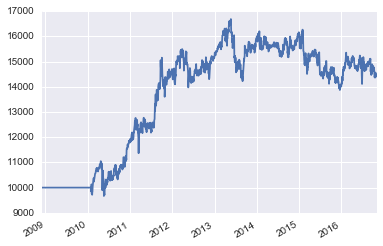

In [6]:
import seaborn as sns
%pylab inline

import pandas as pd
result = pd.read_pickle('E:\\notebooks\\quantopian\\strategies\\result.pkl')

result.portfolio_value.plot()